# Matrializing the Covid dataset

* **Author:** Anders Munk-Nielsen 
* **Ouotput:** `covid.csv`: Each row is a `country` on a `date`. 
* **Source data:**
  * [OWID Covid dataset](https://ourworldindata.org/coronavirus-source-data): Covid dataset with deaths, tests, cases, and time-constant country information. 
  * [Apple mobility data](https://covid19.apple.com/mobility): Daily data on mobility from Apple's devices, the variables `mobility_driving`, `mobility_transit`, `mobility_walking`.
  * [Climate data, from the US' NOAA](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/): Daily data from weather stations across the world. The raw data files are [`2020.csv.gz`](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2020.csv.gz), [`2021.csv.gz`](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2021.csv.gz).
      * Additionally, a list of NOAA country classifications (like ISO2) [`2020_countries.txt`](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt))
  * [Google mobility data](https://www.google.com/covid19/mobility/): the variables `location_retail_and_recreation`,`location_grocery_and_pharmacy`,`location_parks`,`location_transit_stations`,`location_workplaces`,`location_residential`

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set_theme()

In [ ]:
import os 
assert os.path.isdir('./img'), f'There must be an "img" subfolder of the present directory'
assert os.path.isdir('./tab'), f'There must be an "tab" subfolder of the present directory'

# Read in data

In [2]:
dat = pd.read_csv('covid.csv')
dat.date = pd.to_datetime(dat.date) 

# Descriptive plots

<AxesSubplot:xlabel='date'>

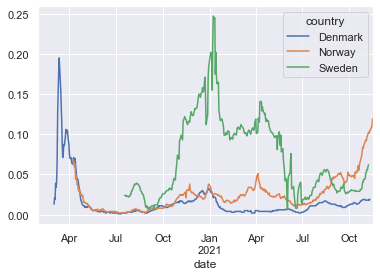

In [4]:
dat[dat.country.isin(['Denmark', 'Sweden', 'Norway'])].groupby(['date', 'country']).positive_rate.mean().unstack().plot()

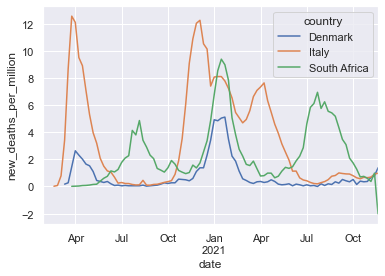

In [5]:
v = 'new_deaths_per_million'
ax = dat[dat.country.isin(['Denmark', 'Italy', 'South Africa'])].groupby([pd.Grouper(key='date', freq='w'), 'country'])[v].mean().unstack().plot()
ax.set_ylabel(v);

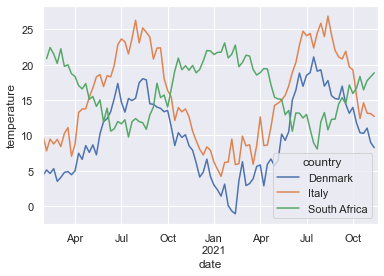

In [6]:
v = 'temperature'
ax = dat[dat.country.isin(['Denmark', 'Italy', 'South Africa'])].groupby([pd.Grouper(key='date', freq='w'), 'country'])[v].mean().unstack().plot()
ax.set_ylabel(v);

## Plots by continent

In [38]:
# Aggregate to weekly frequency to make plots less noisy
dd = dat.groupby([pd.Grouper(key='date', freq='w'), 'continent']).mean()

<AxesSubplot:xlabel='date', ylabel='new_deaths_per_million'>

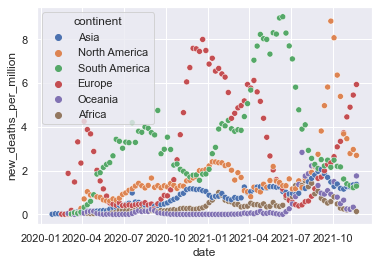

In [ ]:
sns.scatterplot(x='date', y='new_deaths_per_million', hue='continent', data=dd)

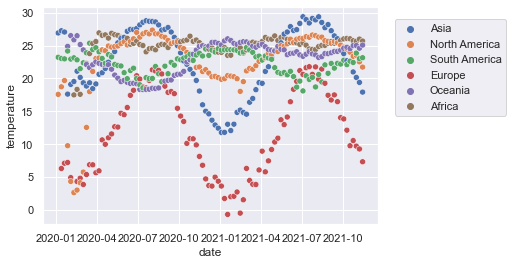

In [39]:
ax = sns.scatterplot(x='date', y='temperature', hue='continent', data=dd); 
ax.legend(loc=(1.05,.5));

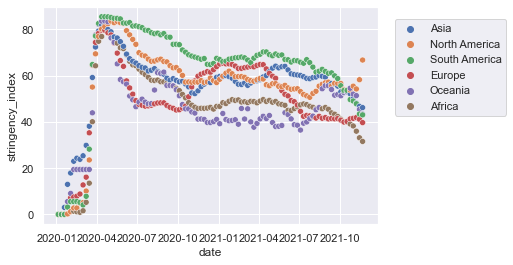

In [40]:
ax = sns.scatterplot(x='date', y='stringency_index', hue='continent', data=dd);
ax.legend(loc=(1.05,.5));

## Mobility patterns have also changed dramatically

Now we dive into the Apple and Google variables regarding mobility and location choices over the pandemic. 

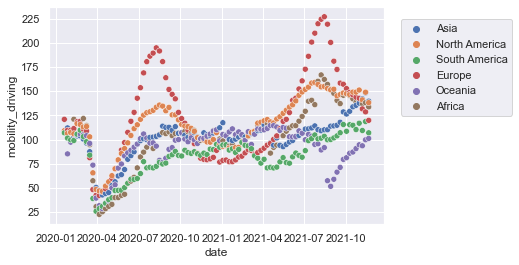

In [ ]:
ax = sns.scatterplot(x='date', y='mobility_driving', hue='continent', data=dd);
ax.legend(loc=(1.05,0.5));

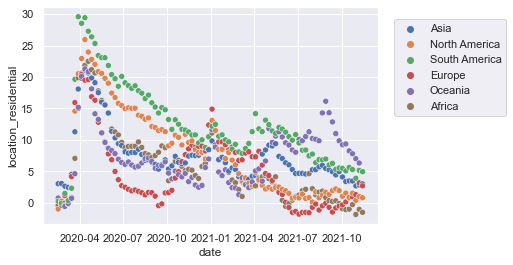

In [ ]:
ax = sns.scatterplot(x='date', y='location_residential', hue='continent', data=dd);
ax.legend(loc=(1.05,0.5));

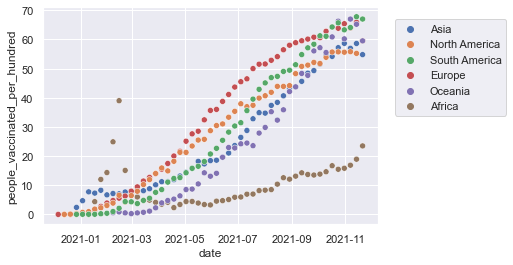

In [ ]:
ax = sns.scatterplot(x='date', y='people_vaccinated_per_hundred', hue='continent', data=dd);
ax.legend(loc=(1.05,0.5));

## Policy responses and the direction of causality

The variable `stringency_index` measures how stringent restrictions are over time in each country. This is a policy variable chosen by politicians in response to the crisis. Therefore, while we believe that there may be a response in mobility to stringency, there is also a response in stringency to a sudden rise in the disease burden. 


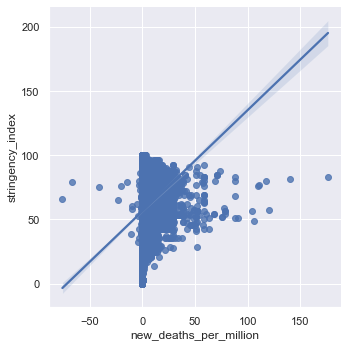

In [ ]:
# dat.plot.scatter('stringency_index', 'new_deaths_per_million')
sns.lmplot(x='new_deaths_per_million', y='stringency_index', data=dat)

## Spatial plots 

Using geopandas, we can visualize the data using maps in a simple way.

In [7]:
import geopandas

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Fix errors in geopandas (tsk!)
if world.query('name == "France"').iso_a3.values[0] == '-99': 
    world.loc[world.name == "France", 'iso_a3'] = 'FRA'
if world.query('name == "Norway"').iso_a3.values[0] == '-99': 
    world.loc[world.name == "Norway", 'iso_a3'] = 'NOR'

def remove_bounding(ax): 
    ax.set_yticklabels([]);
    ax.set_xticklabels([]); 
    ax.set_xticks([]);
    ax.set_yticks([]);
    for l in ['top', 'bottom', 'left', 'right']:
        ax.spines[l].set_visible(False)

def plot_world_map(var, dat, lbl=None, title=None, fname=None, **kwargs):
    assert var in dat.columns, f'Variable "{var}" not in dat columns'
    assert 'iso_code' in dat.columns , f'ISO3 country variable, "iso_code", not found in dat'
    
    # name for chosen variable 
    lbl_var = var # default: just show the variable name 
    if (not lbl is None): 
        if isinstance(lbl, str): 
            lbl_var = lbl 
        elif var in lbl: 
            lbl_var = lbl[var]
        else: 
            print(f'(Var "{var}" not in lbl)')
        
    cols = ['iso_code'] + [var]
    w = pd.merge(world, dat[cols], left_on='iso_a3', right_on='iso_code')
    ax = w.plot(var, cmap = 'OrRd', legend=True, missing_kwds={'color': 'lightgrey', 'label':'hej'},
                 legend_kwds={'label': lbl_var,'orientation': "horizontal"}, **kwargs);
    remove_bounding(ax)
    if not title is None: 
        ax.set_title(title)
    if not fname is None: 
        plt.savefig(fname)

Deaths on the 1st of November.

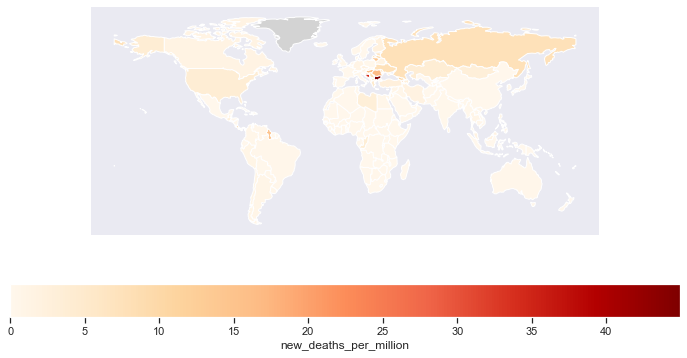

In [9]:
plot_world_map('new_deaths_per_million', dat[dat.date == '2021-11-01'], figsize=(12,6))

Deaths in the month of July

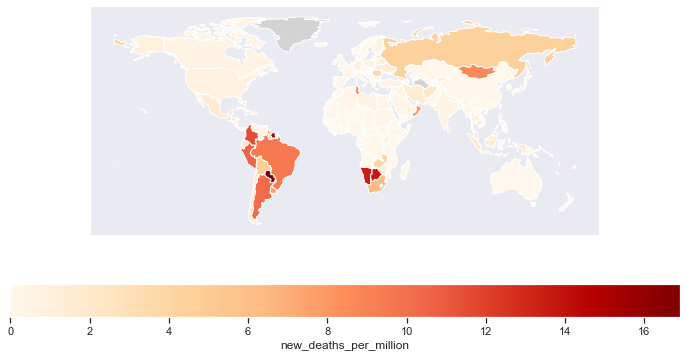

In [10]:
dat_ = dat[dat.date == '2021-07-01'].groupby([pd.Grouper(key='date', freq='m'), 'iso_code']).new_deaths_per_million.mean().reset_index()
plot_world_map('new_deaths_per_million', dat_, figsize=(12,6))

------ y=2020, m=4 ------


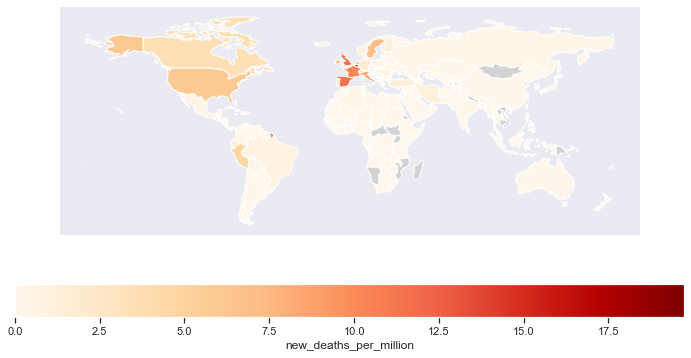

------ y=2020, m=7 ------


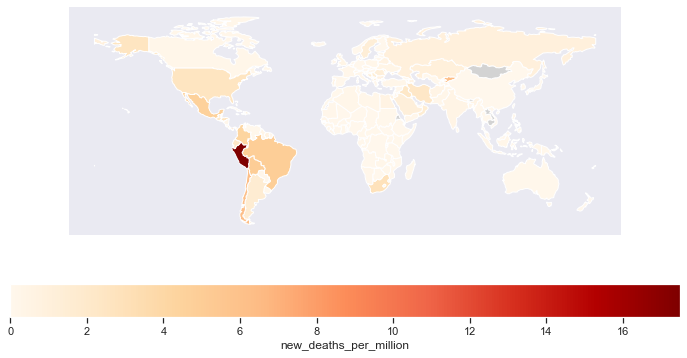

------ y=2020, m=10 ------


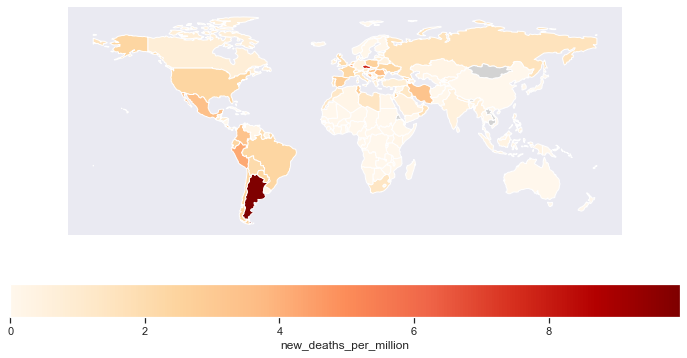

------ y=2021, m=1 ------


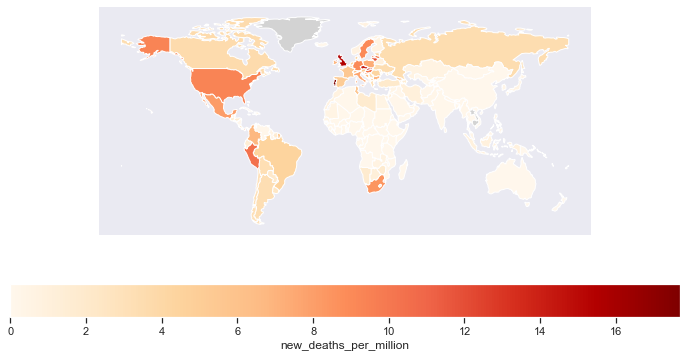

------ y=2021, m=4 ------


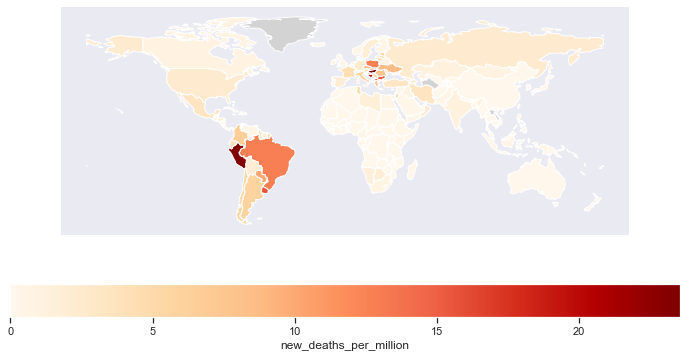

------ y=2021, m=7 ------


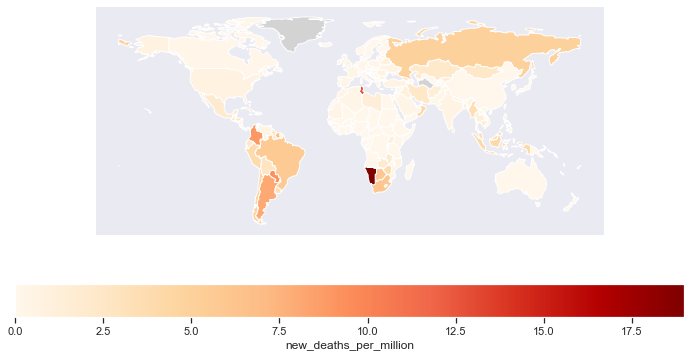

------ y=2021, m=10 ------


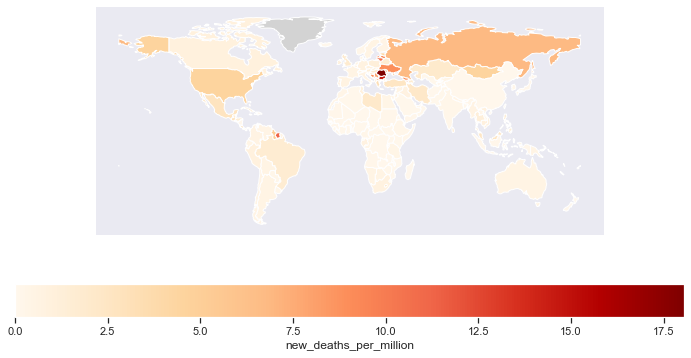

In [11]:
for y in [2020,2021]: 
    for m in [1,4,7,10]:
        if (y == 2020) and (m == 1): 
            continue 
        print(f'------ {y=}, {m=} ------')
        dat_ = dat[(dat.date.dt.month == m) & (dat.date.dt.year == y)].groupby([pd.Grouper(key='date', freq='m'), 'iso_code']).new_deaths_per_million.mean().reset_index()
        plot_world_map('new_deaths_per_million', dat_, figsize=(12,6)) 
        plt.show()

# Using regression techniques

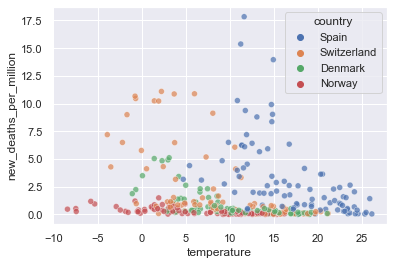

In [12]:
cc = ['Denmark', 'Spain', 'Norway', 'Switzerland']
I = dat.country.isin(cc) & (dat.new_deaths_per_million >= 0.0)
d_ = dat[I].groupby([pd.Grouper(key='date', freq='w'), 'country'])[['temperature', 'new_deaths_per_million']].mean()

sns.scatterplot(x='temperature', y='new_deaths_per_million', data=d_, hue='country', alpha=0.7)
plt.savefig('img/scatter_deaths_vs_temp.pdf')

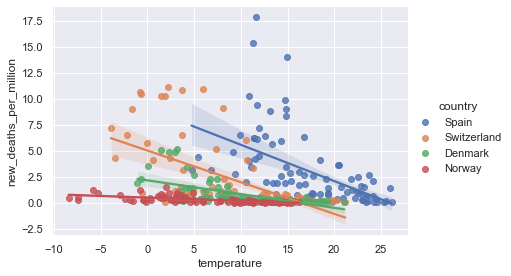

In [13]:
sns.lmplot(x='temperature', y='new_deaths_per_million', data=d_.reset_index(), hue='country', height=4, aspect=1.5)
plt.savefig('img/scatter_regline_deaths_vs_temp.pdf')

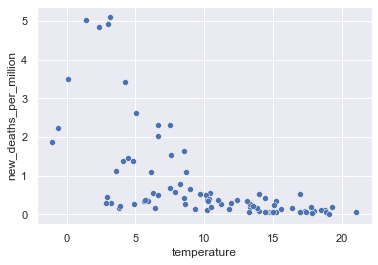

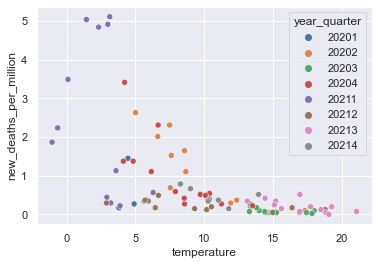

In [14]:
cc = ['Denmark']
I = dat.country.isin(cc) & (dat.new_deaths_per_million >= 0.0)
d_ = dat[I].groupby([pd.Grouper(key='date', freq='w'), 'country'])[['temperature', 'new_deaths_per_million']].mean()

d_.reset_index(inplace=True)
d_['year_quarter'] = (d_.date.dt.year * 10 + d_.date.dt.quarter).astype('category')

sns.scatterplot(x='temperature', y='new_deaths_per_million', data=d_,);
plt.savefig('img/scatter_deaths_vs_temp_denmark_nocol.pdf')
plt.show()
sns.scatterplot(x='temperature', y='new_deaths_per_million', data=d_, hue='year_quarter', cmap='lava');
plt.savefig('img/scatter_deaths_vs_temp_denmark.pdf')
plt.show()

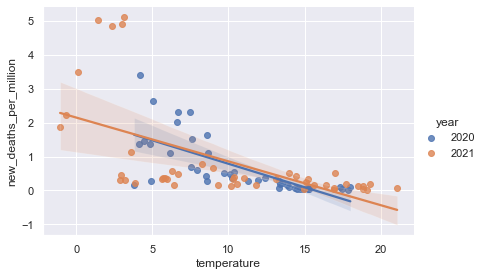

In [15]:
# with a reg line 
d_['year'] = d_.date.dt.year
sns.lmplot(x='temperature', y='new_deaths_per_million', data=d_, hue='year', height=4, aspect=1.5);
plt.savefig('img/scatter_regline_deaths_vs_temp_denmark.pdf')

# Regression setup 

The results below explore models of 
$$ y_{it} = \mathbf{x}_{it} \boldsymbol{\beta} + c_i + \eta_t + \text{error}_{it}, $$
where $y_{it}$ is the number of new deaths per million in country $i$ in week $t$. 

In [24]:
import statsmodels.formula.api as smf

**Missing vaccinations:** The vaccination variable is missing in many many observations. 

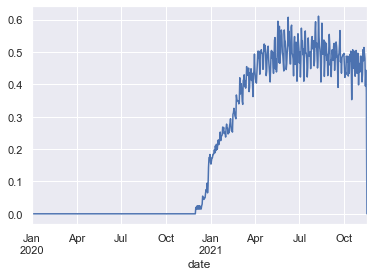

In [25]:
ax = dat.groupby('date').people_vaccinated_per_hundred.agg(lambda x : x.notnull().mean()).plot();
ax.set_ylabel('Share with non-missing vaccination obs.')

In [26]:
dat['people_vaccinated_per_hundred_orig'] = dat.people_vaccinated_per_hundred.copy()
dat.people_vaccinated_per_hundred = dat.people_vaccinated_per_hundred.fillna(0.0) # dangerous!!!

In [27]:
vars = ['people_vaccinated_per_hundred', 'stringency_index', 'temperature']
vars_with_mobil = vars + ['mobility_driving', 'mobility_transit', 'mobility_walking', 'location_residential', 'location_workplaces']
reg_s = ' + '.join(vars)
reg_s_mobil = ' + '.join(vars_with_mobil)

I = dat[vars_with_mobil + ['new_deaths_per_million']].notnull().all(axis=1)
d = dat[I].groupby([pd.Grouper(key='date', freq='w'), 'country', 'continent']).mean().reset_index()

res_no_date = smf.ols(f'new_deaths_per_million ~ {reg_s} + C(continent) + C(date.dt.year)', d).fit()
res_no_date_mobil = smf.ols(f'new_deaths_per_million ~ {reg_s_mobil} + C(continent) + C(date.dt.year)', d).fit()
res_date_FE = smf.ols(f'new_deaths_per_million ~ {reg_s} + C(continent) + C(date)', d).fit()
res_many_FE = smf.ols(f'new_deaths_per_million ~ {reg_s} + C(country) + C(date)', d).fit()

res_mobility_FE = smf.ols(f'new_deaths_per_million ~ {reg_s_mobil} + C(country) + C(date)', d).fit()

bl = {}
fe_w = {}
fe_c = {}
mo = {}
Ns = {}
for res,nam,fe_week,fe_country,mobil in [
                (res_no_date, 'No FE',False,False,False),
                (res_no_date_mobil, 'mobil',False,False,True),
                (res_date_FE, 'week FE',True,False,False),
                (res_many_FE, 'week+country FE',True,True,False),
                (res_mobility_FE, 'FE+mobil',True,True,True)]:
    bl[nam] = res.params.loc[vars]
    fe_w[nam] = fe_week
    fe_c[nam] = fe_country
    mo[nam] = mobil
    Ns[nam] = res.nobs

tab = pd.DataFrame(bl, index=vars)
for this_dict,nam in zip([fe_w, fe_c, mo, Ns],
                     ['Date FE', 'Country FE', 'Mobility variables', 'N']):
    tab = tab.append(pd.DataFrame(this_dict, index=[nam])
                     .astype('object') # <- this avoids making True/False variables into 1.000000 and 0.00000, encoding them as strings instead
                     )
tab.round(4)

,No FE,mobil,week FE,week+country FE,FE+mobil
people_vaccinated_per_hundred,-0.025458,-0.024711,-0.019841,-0.01634,0.002623
stringency_index,0.059576,0.020228,0.045904,0.044345,-0.004175
temperature,-0.071345,-0.042988,0.000297,-0.099173,-0.029536
Date FE,False,False,True,True,True
Country FE,False,False,False,True,True
Mobility variables,False,True,False,False,True
N,2207.0,2207.0,2207.0,2207.0,2207.0


In [28]:
# export our results table to Latex
tab.round(4).to_latex('tab/ols_results.tex')

In [29]:
print(f'y = "new_deaths_per_million": mean = {d.new_deaths_per_million.mean():5.2f}, s.d. = {d.new_deaths_per_million.std(): 5.2f}')

y = "new_deaths_per_million": mean =  2.01, s.d. =  3.09


## What it looked like last year

In the fall of 2020, we were at the cusp of the second wave of Covid: but that was not clear at the time. So in their empirical project, students of the course were trying to predict how bad it would get based on temperature data. 

In [30]:
(dat.date <= '2020-10-01').mean()

0.3216676098849274

In [31]:
vars = ['stringency_index', 'temperature']
vars_with_mobil = vars + ['mobility_driving', 'mobility_transit', 'mobility_walking', 'location_residential', 'location_workplaces']
reg_s = ' + '.join(vars)
reg_s_mobil = ' + '.join(vars_with_mobil)

I = (dat[vars_with_mobil + ['new_deaths_per_million']].notnull().all(axis=1)
     & (dat.date <= '2020-10-01'))
d = dat[I].groupby([pd.Grouper(key='date', freq='w'), 'country', 'continent']).mean().reset_index()

res_no_date = smf.ols(f'new_deaths_per_million ~ {reg_s} + C(continent) + C(date.dt.year)', d).fit()
res_no_date_mobil = smf.ols(f'new_deaths_per_million ~ {reg_s_mobil} + C(continent) + C(date.dt.year)', d).fit()
res_date_FE = smf.ols(f'new_deaths_per_million ~ {reg_s} + C(continent) + C(date)', d).fit()
res_many_FE = smf.ols(f'new_deaths_per_million ~ {reg_s} + C(country) + C(date)', d).fit()

res_mobility_FE = smf.ols(f'new_deaths_per_million ~ {reg_s_mobil} + C(country) + C(date)', d).fit()

bl = {}
fe_w = {}
fe_c = {}
mo = {}
Ns = {}
for res,nam,fe_week,fe_country,mobil in [
                (res_no_date, 'No FE',False,False,False),
                (res_no_date_mobil, 'mobil',False,False,True),
                (res_date_FE, 'week FE',True,False,False),
                (res_many_FE, 'week+country FE',True,True,False),
                (res_mobility_FE, 'FE+mobil',True,True,True)]:
    bl[nam] = res.params.loc[vars]
    fe_w[nam] = fe_week
    fe_c[nam] = fe_country
    mo[nam] = mobil
    Ns[nam] = res.nobs

tab = pd.DataFrame(bl, index=vars)
for this_dict,nam in zip([fe_w, fe_c, mo, Ns],
                     ['Date FE', 'Country FE', 'Mobility variables', 'N']):
    tab = tab.append(pd.DataFrame(this_dict, index=[nam]).astype('object'))
tab.round(4)

,No FE,mobil,week FE,week+country FE,FE+mobil
stringency_index,0.065233,0.009938,0.0399,0.018934,-0.03378
temperature,-0.064778,-0.028992,-0.002081,-0.106996,-0.028646
Date FE,False,False,True,True,True
Country FE,False,False,False,True,True
Mobility variables,False,True,False,False,True
N,762.0,762.0,762.0,762.0,762.0
